# Statistical Modelling
### Linear Regression (base model), Random Forest
1. Feature Selection
2. Use 2022 April as Test Data
3. Modelling
4. Hyper Parameter Tuning

In [1]:
from itertools import chain
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import folium
import matplotlib.pyplot as plt
%matplotlib inline

# statistical model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from statsmodels.formula.api import ols, glm
from sklearn import metrics
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings("ignore")

In [2]:
# train data 2018-2019
df = pd.read_parquet("../data/curated/merged_df.parquet")
df['pu_date'] = pd.to_datetime(df['pu_date'])
df = df.sort_values(by=['pu_date', 'pu_hour']).reset_index(drop=True)

df['pu_day'] = df['pu_date'].dt.day
df['pu_month'] = df['pu_date'].dt.month
df.drop('pu_date', axis=1, inplace=True)

# test data Jan 2020
df_test = pd.read_parquet("../data/curated/merged_test_df.parquet")
df_test['pu_date'] = pd.to_datetime(df_test['pu_date'])
df_test = df_test.sort_values(by=['pu_date', 'pu_hour']).reset_index(drop=True)

df_test['pu_day'] = df_test['pu_date'].dt.day
df_test['pu_month'] = df_test['pu_date'].dt.month
df_test.drop('pu_date', axis=1, inplace=True)

---
## Standardize Data

In [3]:
df.head()

,pu_hour,pu_dow,is_school_holiday,trip_freq,temperature,dew_point,precipitation,wind_direction,visibility,pressure,pu_day,pu_month
0,0,2,1,173,-114.3,-200.300000,0.0,315.000000,16046.5,10260.5,1,1
1,1,2,1,133,-117.5,-206.500000,0.0,330.000000,16093.0,10262.0,1,1
2,2,2,1,33,-122.5,-200.500000,0.0,310.000000,16093.0,10262.0,1,1
3,3,2,1,25,-122.3,-197.300000,0.0,310.000000,16046.5,10262.5,1,1
4,4,2,1,40,-124.5,-198.233333,0.0,316.666667,16093.0,10262.0,1,1


In [4]:
std_col = ['temperature', 'dew_point', 'precipitation', 
           'wind_direction', 'visibility', 'pressure']
df_standard = df[std_col].astype(float).apply(zscore)

df_test_standard = df_test[std_col].astype(float).apply(zscore)

In [5]:
df_test_standard.shape

(744, 6)

In [6]:
df_standard.shape

(17518, 6)

In [7]:
df_standard.describe().loc[['mean','std']]

,temperature,dew_point,precipitation,wind_direction,visibility,pressure
mean,4.964823e-16,-6.691822e-16,-4.015543e-16,-6.655729e-16,1.995017e-16,-5.256213e-15
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00


In [8]:
df_standard.head()

,temperature,dew_point,precipitation,wind_direction,visibility,pressure
0,-2.482008,-2.431581,-0.213048,1.203785,0.373931,1.119520
1,-2.515051,-2.486621,-0.213048,1.355128,0.386613,1.137956
2,-2.566679,-2.433356,-0.213048,1.153337,0.386613,1.137956
3,-2.564614,-2.404948,-0.213048,1.153337,0.373931,1.144101
4,-2.587330,-2.413234,-0.213048,1.220601,0.386613,1.137956


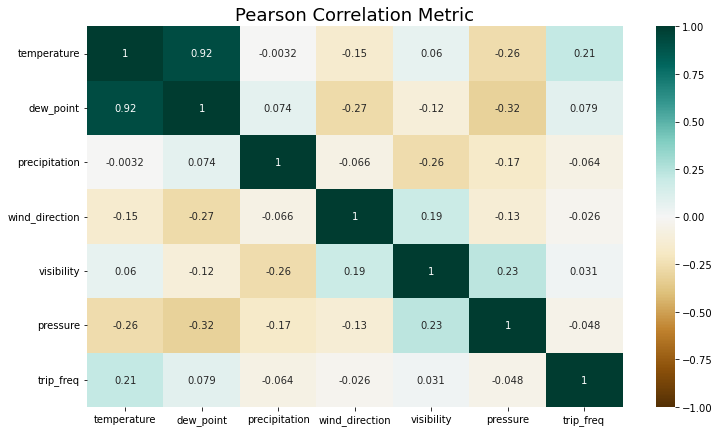

In [9]:
plt.figure(figsize=(12,7))
sns.heatmap(pd.concat([df_standard, df[['trip_freq']]], axis=1).corr(), 
            vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.title('Pearson Correlation Metric', fontsize=18)
plt.show()

In [10]:
df_fit = pd.concat([df_standard, df[['trip_freq']]], axis=1)
# try another model without dew_point
fitter = ols(
    formula="trip_freq ~ temperature + precipitation + wind_direction + visibility + pressure",
    data=df_fit
).fit()

In [11]:
# try another model without temperature
fitter1 = ols(
    formula="trip_freq ~ dew_point + precipitation + wind_direction + visibility + pressure",
    data=df_fit
).fit()

In [12]:
fitter.aic, fitter1.aic

(228448.92149455033, 229035.64662512235)

As Temperature and Dew point are very highly correlated, it is as expected that we should remove one of them to minimise complexity in the model. Using the AIC score, it is obvious that the model without dew_point has the lowest AIC. Hence, moving forward we will remove this feature.


In [13]:
valid_col = ["temperature", "precipitation", "wind_direction",
             "visibility", "pressure"]
df_standard = df_standard[valid_col]
df_test_standard = df_test_standard[valid_col]

---
## One-hot encode categorical variable

In [14]:
x_col = ['pu_hour', 'pu_dow', 'pu_day', 'pu_month']

enc = pd.get_dummies(df['pu_hour'], prefix='pu_hour')
for feature in x_col[1:]:
    df_feat = pd.get_dummies(df[feature], prefix=feature)
    enc = pd.concat([enc, df_feat], axis=1)

test_enc = pd.get_dummies(df_test['pu_hour'], prefix='pu_hour')
for feature in x_col[1:]:
    df_feat = pd.get_dummies(df_test[feature], prefix=feature)
    test_enc = pd.concat([test_enc, df_feat], axis=1)
for m in range(2, 13):
    test_enc[f'pu_month_{str(m)}'] = 0


In [15]:
enc.shape

(17518, 74)

In [16]:
test_enc.shape

(744, 74)

---
### Combine the standardized continuous features and one-hot encoded ordinal features into one dataframe

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17518 entries, 0 to 17517
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pu_hour            17518 non-null  int32  
 1   pu_dow             17518 non-null  int32  
 2   is_school_holiday  17518 non-null  int32  
 3   trip_freq          17518 non-null  int64  
 4   temperature        17518 non-null  float64
 5   dew_point          17518 non-null  float64
 6   precipitation      17518 non-null  float64
 7   wind_direction     17518 non-null  float64
 8   visibility         17518 non-null  float64
 9   pressure           17518 non-null  float64
 10  pu_day             17518 non-null  int64  
 11  pu_month           17518 non-null  int64  
dtypes: float64(6), int32(3), int64(3)
memory usage: 1.4 MB


In [18]:
X_train = pd.concat([df_standard, enc, df[['is_school_holiday']]], axis=1)
X_test = pd.concat([df_test_standard, test_enc, df_test[['is_school_holiday']]]
                   , axis=1)

In [19]:
X_train.shape, X_test.shape

((17518, 80), (744, 80))

In [20]:
scaler_y_train = StandardScaler().fit(df[['trip_freq']])
y_train = np.ravel(scaler_y_train.transform(df[['trip_freq']]))

scaler_y_test = StandardScaler().fit(df_test[['trip_freq']])
y_test = np.ravel(scaler_y_test.transform(df_test[['trip_freq']]))


---
# Multiple Linear Regression (base model)

In [21]:
lr = LinearRegression().fit(X_train, y_train)
rmse_cv = cross_val_score(lr, X_train, y_train, cv=5, 
                         scoring='neg_root_mean_squared_error')
r2_cv = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
print(f'RMSE: {abs(np.mean(rmse_cv))}')
print(f'R2-score: {np.mean(r2_cv)}')
    

RMSE: 0.4420996151349339
R2-score: 0.8004366773105127


In [22]:
y_pred = lr.predict(X_test)

In [23]:
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [24]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(df_test['trip_freq'], y_pred_actual)),
      'trips.')
print('Root Mean Absolute Percentage Error:', 
      metrics.mean_absolute_percentage_error(df_test['trip_freq'],
                                             y_pred_actual))

print('R^2 Score:', metrics.r2_score(df_test['trip_freq'], y_pred_actual))

Root Mean Squared Error: 71.47556245782395 trips.
Root Mean Absolute Percentage Error: 0.3068183791594073
R^2 Score: 0.8065036454512429


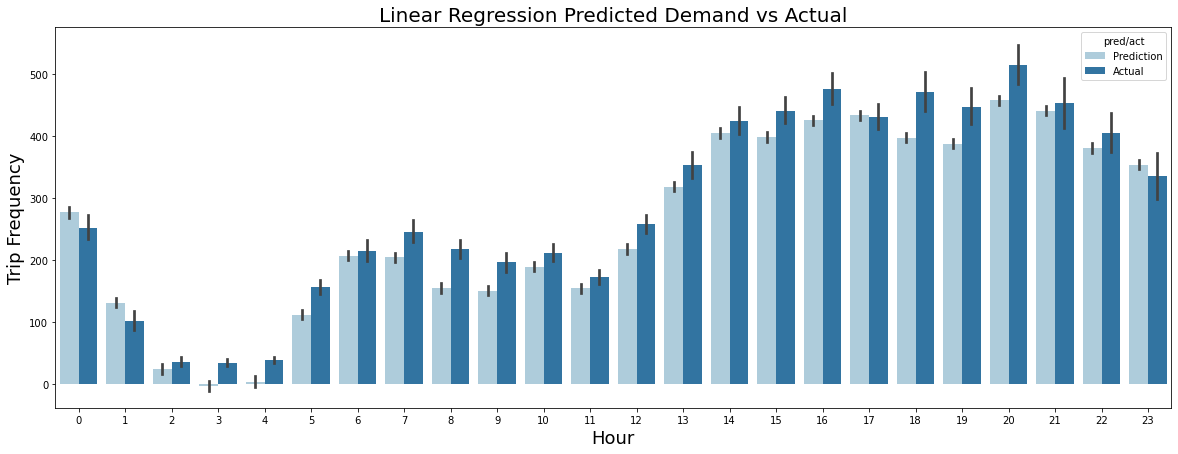

In [25]:
df1 = pd.DataFrame({'trip_freq':y_pred_actual})
df1['pu_hour'] = df_test['pu_hour']
df1['pu_day'] = df_test['pu_day']
df1['pred/act'] = 'Prediction'

df2 = df_test[['pu_hour', 'pu_day', 'trip_freq']]
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

plt.figure(figsize=(20, 7))
sns.barplot(
    x="pu_hour", y="trip_freq", hue="pred/act", data=df_visualise, ci=95, 
    palette="Paired"
)
plt.xlabel("Hour", fontsize=18)
plt.ylabel("Trip Frequency", fontsize=18)
plt.title("Linear Regression Predicted Demand vs Actual", fontsize=20)
plt.savefig(f'../plots/lr_hour_pred_act.png')



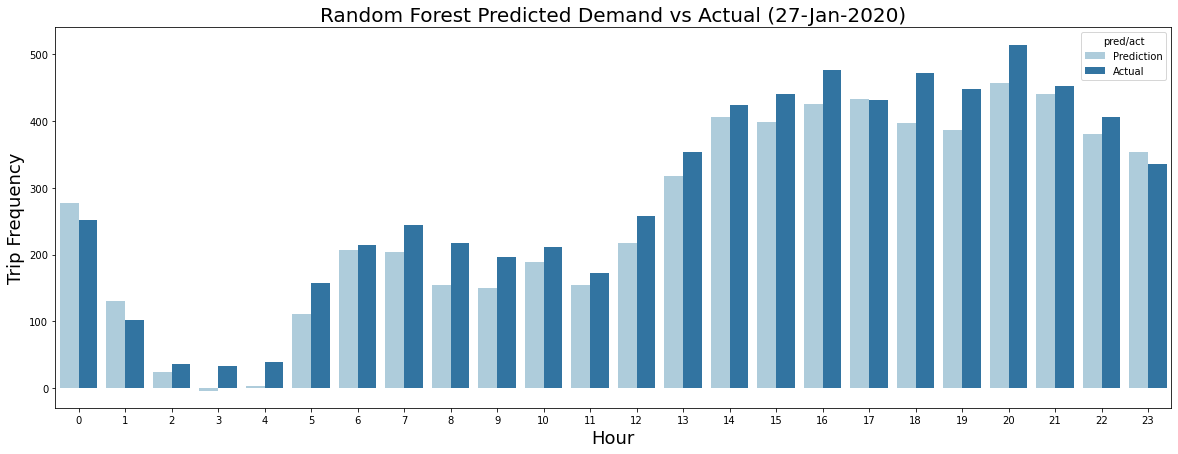

In [26]:

# look at 1 specific day 27 Jan 2020
df27 = df1[df1['pu_day'] == 27]
df27 = df2[df2['pu_day'] == 27]

df_visualise_27 = pd.concat([df1, df2],axis=0)

plt.figure(figsize=(20, 7))
sns.barplot(
    x="pu_hour", y="trip_freq", hue="pred/act", data=df_visualise_27, ci=None, 
    palette="Paired"
)
plt.xlabel("Hour", fontsize=18)
plt.ylabel("Trip Frequency", fontsize=18)
plt.title("Random Forest Predicted Demand vs Actual (27-Jan-2020)", 
          fontsize=20)
plt.savefig(f'../plots/lr_hour_pred_act_20200127.png')



It is evident that the model is struggling to estimate demand during dawn time (3-4 am), but this is a good enough base model.

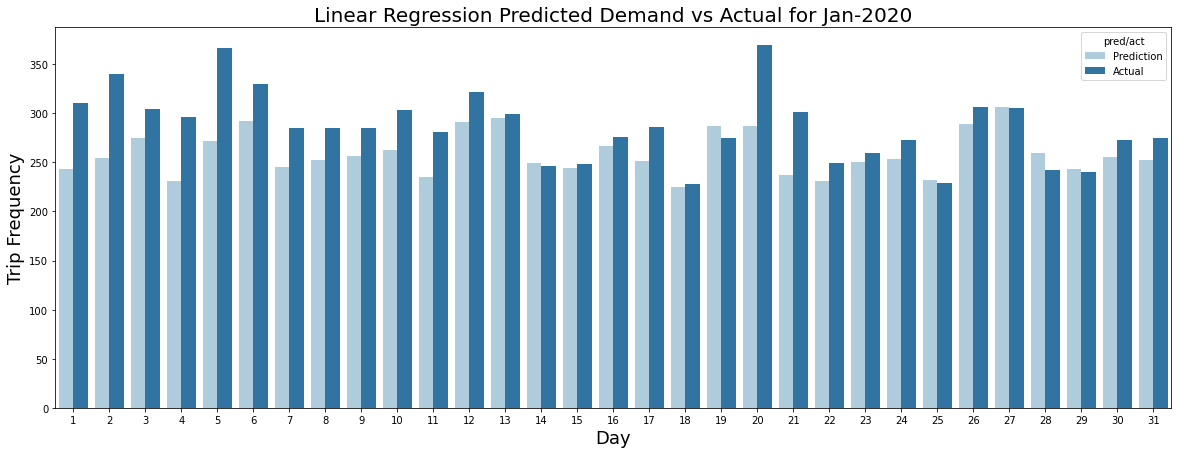

In [27]:
plt.figure(figsize=(20,7))
sns.barplot(
    x="pu_day", y="trip_freq", hue="pred/act", data=df_visualise, ci=None,
    palette="Paired"
)
plt.xlabel("Day", fontsize=18)
plt.ylabel("Trip Frequency", fontsize=18)
plt.title("Linear Regression Predicted Demand vs Actual for Jan-2020",
          fontsize=20)
plt.savefig(f'../plots/lr_hour_pred_act_jan2020.png')

---
# Random Forest Modelling
Use Random Forest as it is able to capture complex decision boundaries relationship between features.

### Hyperparameter Tuning (max_feature and n_estimator)

In [28]:
for mf in ("sqrt", "log2", 10, 15, None):
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    print(f"max_features = {mf}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))

max_features = sqrt: 	 R2-score: 0.8310009133916697 	RMSE: 0.4073575982159482
max_features = log2: 	 R2-score: 0.8247388910266542 	RMSE: 0.4151546522008001
max_features = 10: 	 R2-score: 0.8338630659646611 	RMSE: 0.4038016939134691
max_features = 15: 	 R2-score: 0.8359065003892903 	RMSE: 0.40115600171661175
max_features = None: 	 R2-score: 0.8261643357394147 	RMSE: 0.4124224315336285


In [41]:
rmse = []
r2 = []
for mf in range(15, 21):
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    rmse.append(abs(np.mean(rmse_cv)))
    
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    r2.append(np.mean(r2_cv))
#     print(f"max_features = {mf}: \t", 'R2-score:', np.mean(r2_cv), 
#           '\tRMSE:', abs(np.mean(rmse_cv)))


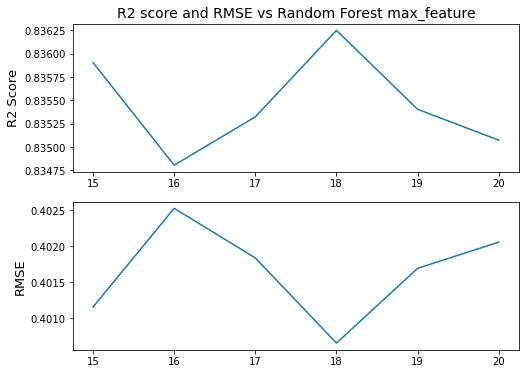

In [42]:
mfs = range(15, 21)
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(mfs)), r2, label='R2')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('R2 Score', fontsize=13)
plt.title('R2 score and RMSE vs Random Forest max_feature', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(mfs)), rmse, label='RMSE')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_hype_tuning_maxf.png')

When max_feature = 18, the model has highest r2 score and lowest RMSE.

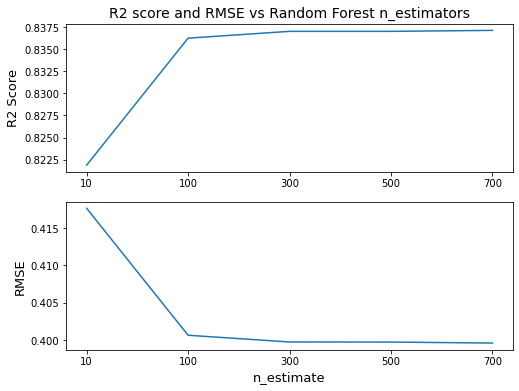

In [31]:
rmse = []
r2 = []
ests = (10, 100, 300, 500, 700)


for n_est in ests:
    rf = RandomForestRegressor(n_estimators=n_est, random_state = 42, 
                               max_features=18)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    
    rmse.append(abs(np.mean(rmse_cv)))
    r2.append(np.mean(r2_cv))
    
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(ests)), r2, label='R2')
plt.xticks(range(len(ests)), ests)
plt.ylabel('R2 Score', fontsize=13)
plt.title('R2 score and RMSE vs Random Forest n_estimators', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(ests)), rmse, label='RMSE')
plt.xticks(range(len(ests)), ests)
plt.xlabel('n_estimate', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_hype_tuning_nest.png')

When n_estimators = 500, the model has best r2 score and lowest RMSE.

In [45]:
rf = RandomForestRegressor(n_estimators = 300, max_features=18, 
                           random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=18, n_estimators=300, random_state=42)

### Prediction and Evaluation

In [46]:
y_pred = rf.predict(X_test)

In [47]:
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [48]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(df_test['trip_freq'], y_pred_actual)),
      'trips.')
print('Root Mean Absolute Percentage Error:', 
      metrics.mean_absolute_percentage_error(df_test['trip_freq'],
                                             y_pred_actual))
print('R^2 Score:', metrics.r2_score(df_test['trip_freq'], y_pred_actual))

Root Mean Squared Error: 66.13023057225912 trips.
Root Mean Absolute Percentage Error: 0.2616893867965855
R^2 Score: 0.83436286955667


### Prediction vs Actual Visualization

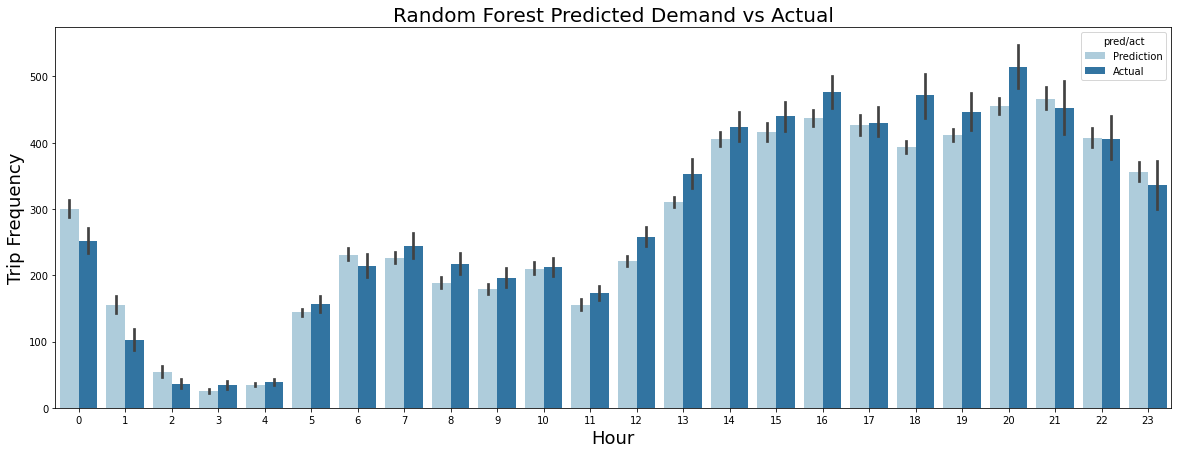

In [51]:
df1 = pd.DataFrame({'trip_freq':y_pred_actual})
df1['pu_hour'] = df_test['pu_hour']
df1['pu_day'] = df_test['pu_day']
df1['pred/act'] = 'Prediction'

df2 = df_test[['pu_hour', 'pu_day', 'trip_freq']]
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

plt.figure(figsize=(20, 7))
sns.barplot(
    x="pu_hour", y="trip_freq", hue="pred/act", data=df_visualise, ci=95, 
    palette="Paired"
)
plt.xlabel("Hour", fontsize=18)
plt.ylabel("Trip Frequency", fontsize=18)
plt.title("Random Forest Predicted Demand vs Actual", fontsize=20)
plt.savefig(f'../plots/rf_hour_pred_act.png')


Interestingly, the model is very optimistic during the morning peaks, and appears to have become more pessimistic after noon.

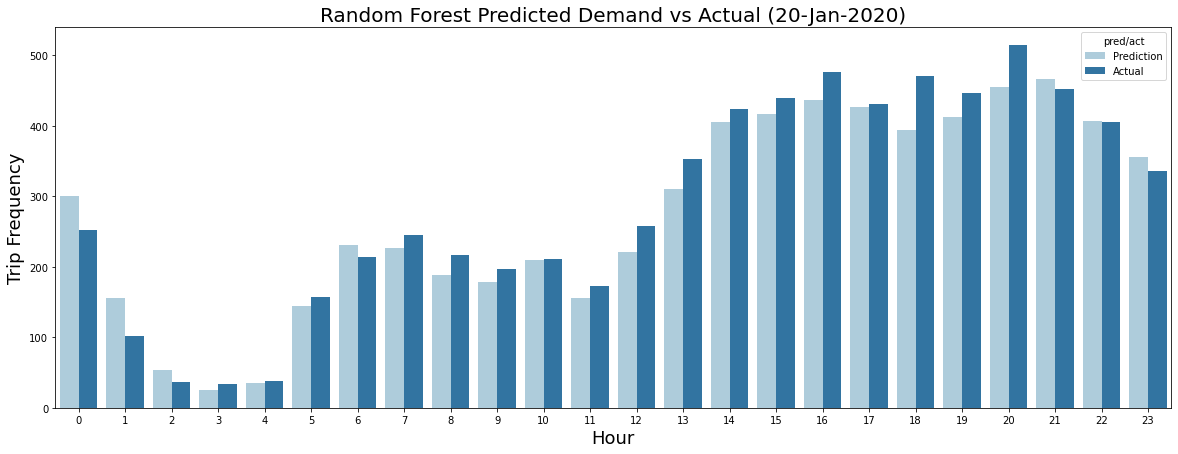

In [54]:

# look at 1 specific day 20 Jan 2020
df27 = df1[df1['pu_day'] == 20]
df27 = df2[df2['pu_day'] == 20]

df_visualise_27 = pd.concat([df1, df2],axis=0)

plt.figure(figsize=(20, 7))
sns.barplot(
    x="pu_hour", y="trip_freq", hue="pred/act", data=df_visualise_27, ci=None, 
    palette="Paired"
)
plt.xlabel("Hour", fontsize=18)
plt.ylabel("Trip Frequency", fontsize=18)
plt.title("Random Forest Predicted Demand vs Actual (20-Jan-2020)", fontsize=20)
plt.savefig(f'../plots/rf_hour_pred_act_20220120.png')


This model estimation during 3-4 am matches the actual, unlike linear regression prediction

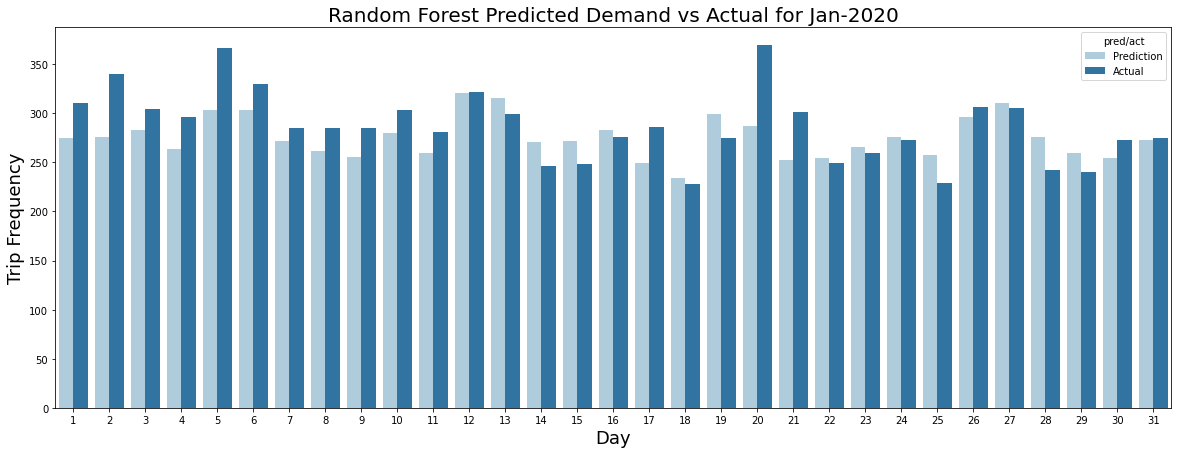

In [38]:
plt.figure(figsize=(20,7))
sns.barplot(
    x="pu_day", y="trip_freq", hue="pred/act", data=df_visualise, ci=None,
    palette="Paired"
)
plt.xlabel("Day", fontsize=18)
plt.ylabel("Trip Frequency", fontsize=18)
plt.title("Random Forest Predicted Demand vs Actual for Jan-2020", fontsize=20)
plt.savefig(f'../plots/rf_hour_pred_act_jan_2020.png')

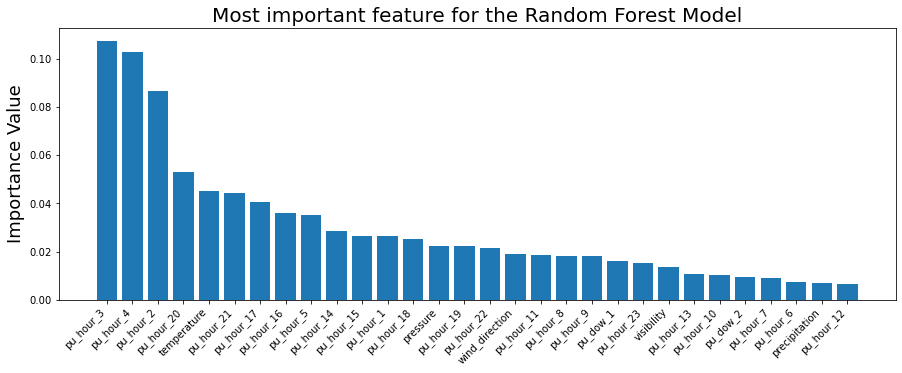

In [49]:
# visualise feature importance value
importances = list(rf.feature_importances_)
df_imp = (pd.DataFrame({'feature':X_train.columns.tolist(), 'importances':importances})
            .sort_values(by='importances', ascending=False).reset_index(drop=True))

df_imp_top30 = df_imp[:30]
plt.figure(figsize=(15,5))
plt.bar('feature', 'importances', orientation = 'vertical', data=df_imp_top30)
plt.xticks(rotation=45, ha="right")
plt.xlabel("", fontsize=18)
plt.ylabel("Importance Value", fontsize=18)
plt.title("Most important feature for the Random Forest Model", fontsize=20)
plt.savefig(f'../plots/rf_important_feat.png', bbox_inches='tight')
